In [1]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

In [23]:
# print Read distribution per sample in 'filtered' as 'just_want_to_see_depth.pdf'

see_read_depth_sample <- function(vcf){
    names(vcf)
    pdf(file="just_want_to_see_depth.pdf",height=6,width=30)
    a<-ggplot(vcf, aes(x=ID, y=log10(REF_COUNT+ALT_COUNT)))+
    geom_violin()+
    geom_hline(yintercept=3,linetype=2,col="blue")+
    theme_bw()+
    theme(axis.text.x=element_text(face="bold",size=8,angle=90))
    print(a)
    dev.off()
    }

#------------------------------------------------------------------------------------
      
filtering_error_prone_variants<- function(data) {
    filtered <- data[ data$REPEAT_MASKER==0 
               & data$SEGDUP==FALSE 
               & data$HOMOPOLYMER==FALSE 
               & data$DINUCLEOTIDE==FALSE 
               & data$NEAR_INDEL==FALSE 
               & data$UCSC_RPMSK=='pass',]
    return(filtered)
    }

#------------------------------------------------------------------------------------

Calculating_cuttoff_het <- function(vcf, WGS_variants_path){
    WGS_var<-read.table(file=WGS_variants_path, header=T, row.names=NULL)
    #load potential heterozygous variants
    WGS_het_var <- subset(WGS_var, Category == "Het")
    print(paste("number of rows of potential het: ", nrow(WGS_het_var)))
    # overlaping variants between WGS potential variants and vcf data
    overlap <- subset(vcf, vcf$CHROM.POS.REF.ALT %in% WGS_het_var$CHROM.POS.REF.ALT)
    print(paste("number of rows of overlapping het between WGS potential variants and vcf data: ",nrow(overlap)))

    # Generate histogram for the MAF upper and lower CI of potential het variants 
    pdf(file="potential_het_var_MAF_hist.pdf",height=6,width=20)
    par(mfrow=c(1,3),mar=c(3, 3, 1, 1))
    hist(sqrt(overlap$MAF), breaks = 500, xlim=c(0,1), ylim=c(0,3000))

    hist(sqrt(overlap$LOWER_CI), breaks = 500, xlim=c(0,1), ylim=c(0,3000))
    abline(v=quantile(sqrt(overlap$LOWER_CI), 0.975, na.rm=TRUE), col="red")
    abline(v=quantile(sqrt(overlap$LOWER_CI), 0.025, na.rm=TRUE), col="red")

    hist(sqrt(overlap$UPPER_CI), breaks = 500, xlim=c(0,1), ylim=c(0,3000))
    abline(v=quantile(sqrt(overlap$UPPER_CI), 0.975, na.rm=TRUE), col="red")
    abline(v=quantile(sqrt(overlap$UPPER_CI), 0.025, na.rm=TRUE), col="red")
    dev.off()
    
    # upper and lower limit of definition of the het variant
    print(quantile(overlap$LOWER_CI, 0.975, na.rm=TRUE))
    print(quantile(overlap$LOWER_CI, 0.025, na.rm=TRUE))
    print(quantile(overlap$UPPER_CI, 0.975, na.rm=TRUE))
    print(quantile(overlap$UPPER_CI, 0.025, na.rm=TRUE))
    }

#------------------------------------------------------------------------------------

Calculating_cuttoff_homo <- function(vcf, WGS_variants_path){
    WGS_var<-read.table(file=WGS_variants_path, header=T, row.names=NULL)
    #load potential heterozygous variants
    WGS_homo_var <- subset(WGS_var, Category == "Alt_Homo")
    print(paste("number of rows of potential homo: ", nrow(WGS_homo_var)))

    # overlaping variants between WGS potential variants and vcf data
    overlap <- subset(vcf, vcf$CHROM.POS.REF.ALT %in% WGS_homo_var$CHROM.POS.REF.ALT)
    head(overlap)
    print(paste("number of rows of overlapping homo between WGS potential variants and vcf data: ",nrow(overlap)))

    # Generate histogram for the MAF upper and lower CI of potential homo variants 
    pdf(file="potential_homo_var_MAF_hist.pdf",height=6,width=7)
    hist(sqrt(overlap$LOWER_CI), breaks = 500, xlim=c(0,1), ylim=c(0,3000))
    abline(v=quantile(sqrt(overlap$LOWER_CI), 0.95, na.rm=TRUE), col="red")
    dev.off()
    
    # lower limit of AF to define 'mosaic variant
    print(quantile(overlap$LOWER_CI, 0.95, na.rm=TRUE))
    }

#------------------------------------------------------------------------------------

refine_mosaic_variant_by_cutoff<- function(vcf, WGS_variants_path, Mosaic_LOWER, Mosaic_UPPER){
    WGS_var <- read.table(file=WGS_variants_path, header=T, row.names=NULL)
    #load potential heterozygous variants
    WGS_mosaic_var <- subset(WGS_var, Category %in% c( "Mosaic"))
    overlap <- subset(vcf, vcf$CHROM.POS.REF.ALT %in% WGS_mosaic_var$CHROM.POS.REF.ALT)
    overlap<-subset(overlap, (overlap$LOWER_CI>Mosaic_LOWER & overlap$UPPER_CI<Mosaic_UPPER & overlap$NORMAL_LOWER_CI<Mosaic_LOWER))
    head(overlap)
    print(paste("number of rows: ",nrow(overlap)))
    print(paste("number of variants: ", length(unique(overlap$CHROM.POS.REF.ALT))))
    pdf(file="potential_mosaic_var_MAF_hist.pdf",height=6,width=10)
    hist(overlap$LOWER_CI, breaks = 100, xlim=c(Mosaic_LOWER,Mosaic_UPPER))
    dev.off()
    return(overlap)
    }


# Remove samples that have low depth and heart samples

In [4]:
# Load final_summary.vcf as 'raw'
raw<-read.table(file="/projects/ps-gleesonlab8/Uniformly_processed_data/20230111_Changuk_Ampliseq_7614_interneuron_heart_IGM/2_Annotation/7614_final_summary.vcf",header=T)
see_read_depth_sample(raw)    

Warning message:
“Removed 52962 rows containing non-finite values (`stat_ydensity()`).”


png 
  2

In [5]:
filtered<-subset(raw, !(raw$ID 
                        %in% c("7614-Heart-ART-1-bulk", "7614-Heart-ART-2-bulk","7614-Heart-IVS-1-bulk","7614−Heart-LV-10-bulk","7614-Heart-RA-3-bulk",
                              "7614-Heart-RA-4-bulk","7614-Heart-RA-6-bulk","7614-Heart-RA-7-bulk","7614-Heart-RA-9-bulk","7614-L-F-Olig2","7614-L-O-NeuN",
                              "7614-L-O-Olig2","7614-R-2-GP-COUPTF2","7614-R-2-Put-DARPP32P-NeuNP","7614-R-4-Put-DARPP32P-NeuNP","7614-R-5-put","7614-R-PF-Olig2",
                              "7614-R-T-Olig2")
                               #"7614−R−PF−DLX1","7614−R−T−72-TBR1","7614−R−T−74-TBR1","7614−R−P−DLX1")
                       ))
#filtered<-filtered[!grepl('Heart',filtered$ID),]

length(unique(filtered$ID)) 
filtered$CHROM.POS.REF.ALT <- NA
filtered$Mosaic <- NA
filtered$CHROM.POS.REF.ALT <- paste(filtered$CHROM,"-",filtered$POS,"-",filtered$REF,"-",filtered$ALT, sep="")
filtered <- relocate(filtered, CHROM.POS.REF.ALT, .after = ALT)

[1] 321

In [6]:
filtered<-subset(filtered, !(filtered$CHROM.POS.REF.ALT 
                        %in% c("7-130475210-A-T","7-65610988-C-T","11-18932963-G-A","15-95432589-G-A")))

write.table(filtered,"./7614_final_summary_anno3.txt",sep="\t", row.names=FALSE, col.names=TRUE)

# Set cut off of AF

In [12]:
#filtered<-read.table(file="./final_summary_anno3.txt",header=T)
filtered<-read.table(file="./7614_final_summary_anno3.txt",header=T)

In [13]:
#remove JGG for cutoff calculation
filtered_noJGG<-filtered[!(filtered$ID %in% c("JGG","JGG-bulk","JGG-sorted")),]
filtered_noJGG<-filtering_error_prone_variants(filtered_noJGG)

In [14]:
variant_list<-read.table(file="./7614-variant-list.txt",header=T)

In [15]:
variant_list$CHROM.POS.REF.ALT <- paste(variant_list$CHROM,"-",variant_list$POS,"-",variant_list$REF,"-",variant_list$ALT, sep="")
variant_list <- relocate(variant_list, CHROM.POS.REF.ALT, .after = ALT)
#write.table(variant_list,"./7614-variant-list.txt",sep="\t", row.names=FALSE, col.names=TRUE)

In [24]:
Calculating_cuttoff_het(filtering_error_prone_variants(filtered_noJGG), "./7614-variant-list.txt")

[1] "number of rows of potential het:  120"
[1] "number of rows of overlapping het between WGS potential variants and vcf data:  29574"
    97.5% 
0.5354356 
     2.5% 
0.3923302 
    97.5% 
0.6022849 
     2.5% 
0.4706769 


In [25]:
Calculating_cuttoff_homo(filtering_error_prone_variants(filtered_noJGG), "./7614-variant-list.txt")

[1] "number of rows of potential homo:  30"
[1] "number of rows of overlapping homo between WGS potential variants and vcf data:  9222"


Warning message in sqrt(overlap$LOWER_CI):
“NaNs produced”
Warning message in sqrt(overlap$LOWER_CI):
“NaNs produced”


        95% 
0.001677998 


# refine mosaic variant by cutoff

In [17]:
# Load final_summary.txt
filtered<-read.table(file="./7614_final_summary_anno3.txt",header=T)
#filtered_bulk<-filtered[grepl("_Bulk",filtered$ID),]
MV_by_cutoff<-refine_mosaic_variant_by_cutoff(filtered, "./7614-variant-list.txt",0.001677998 ,0.4706769)

[1] "number of rows:  24689"
[1] "number of variants:  557"


In [14]:
filtered[filtered$CHROM.POS.REF.ALT %in% MV_by_cutoff$CHROM.POS.REF.ALT,]$Mosaic<-1
filtered[!(filtered$CHROM.POS.REF.ALT %in% MV_by_cutoff$CHROM.POS.REF.ALT),]$Mosaic<-0

In [21]:
names(filtered)
raw2<-filtered[filtered$Mosaic==1,]
bks=c(0,0.001677998,0.005,0.1,0.20,0.3,0.3923302,0.4,0.5,0.6,1)
pdf(file="Interneuron_7614_2023_01_16_Plot.pdf",width=32,height=9)

suppressWarnings( for(i in 1:557){
temp<-raw2[raw2$CHROM.POS.REF.ALT==names(table(raw2$CHROM.POS.REF.ALT))[i],]
plot <-
ggplot(temp,aes(x=ID,y=sqrt(MAF),ymin=sqrt(LOWER_CI),ymax=sqrt(UPPER_CI)))+
	geom_point(alpha=0.5)+
	geom_pointrange()+
	geom_hline(yintercept=sqrt(0.001677998),linetype=2,col="black")+
  	geom_hline(yintercept=sqrt(0.3923302),linetype=2,col="black")+

	geom_hline(yintercept=sqrt(0.005),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.6),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.5),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.4),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(1),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0),linetype=2,col="grey")+
	scale_y_continuous(breaks=sqrt(bks),labels=bks)+
	scale_color_manual(values = c("pink","#2A3280","#A73326","#666666","#CCCCCC"))+
	theme_classic()+
	labs(title=names(table(raw2$CHROM.POS.REF.ALT))[i],x="")+
	theme(axis.line=element_blank(),axis.text.x=element_text(face="bold",size=5,angle=90,vjust = 0.5))+
	geom_segment(aes(x = 0, y = 0, xend = 0, yend = 1),color="black")
print(plot)
}
)
dev.off()

[1] "ID"                   "CHROM"                "POS"                 
 [4] "REF"                  "ALT"                  "CHROM.POS.REF.ALT"   
 [7] "ANNO"                 "GENE"                 "GNOMAD_FREQ"         
[10] "REPEAT_MASKER"        "SEGDUP"               "HOMOPOLYMER"         
[13] "REF_SEQ"              "DINUCLEOTIDE"         "NEAR_INDEL"          
[16] "UCSC_RPMSK"           "REF_COUNT"            "ALT_COUNT"           
[19] "MAF"                  "LOWER_CI"             "UPPER_CI"            
[22] "CI_IS_GREATER"        "NORMAL_REF_COUNT"     "NORMAL_ALT_COUNT"    
[25] "NORMAL_MAF"           "NORMAL_LOWER_CI"      "NORMAL_UPPER_CI"     
[28] "NORMAL_CI_IS_GREATER" "Mosaic"

png 
  2

In [22]:
nrow(filtered[filtered$Mosaic==1,])
names(filtered[filtered$Mosaic==1,])

nrow(MV_by_cutoff)

[1] 178797

[1] "ID"                   "CHROM"                "POS"                 
 [4] "REF"                  "ALT"                  "CHROM.POS.REF.ALT"   
 [7] "ANNO"                 "GENE"                 "GNOMAD_FREQ"         
[10] "REPEAT_MASKER"        "SEGDUP"               "HOMOPOLYMER"         
[13] "REF_SEQ"              "DINUCLEOTIDE"         "NEAR_INDEL"          
[16] "UCSC_RPMSK"           "REF_COUNT"            "ALT_COUNT"           
[19] "MAF"                  "LOWER_CI"             "UPPER_CI"            
[22] "CI_IS_GREATER"        "NORMAL_REF_COUNT"     "NORMAL_ALT_COUNT"    
[25] "NORMAL_MAF"           "NORMAL_LOWER_CI"      "NORMAL_UPPER_CI"     
[28] "NORMAL_CI_IS_GREATER" "Mosaic"

[1] 24689

In [23]:
write.table(filtered,"./7614_final_summary_anno3.txt",sep="\t", row.names=FALSE, col.names=TRUE)

In [24]:
write.csv(filtered$CHROM.POS.REF.ALT,"7614_557_variants.csv")

# Add Ampliseq_ID to WGS variant call list

In [25]:
WGS_calls <-read.table(file="/projects/ps-gleesonlab8/User/chchung/Interneuron/7614_WGS_raw_calls/2022_05_18_MH_MF_S2_M2_DM.txt",header=T) # WGS raw variant calls

In [26]:
# want to know if the variants are called in both WGS and ampliseq within the same tissue
filtered<-read.table(file="./7614_final_summary_anno3.txt",header=T) # JGG included, 9 low quality sample excluded already

In [27]:
unique(WGS_calls$ID)

[1] "7614-H-LA5"    "7614-H-LV5"    "7614-H-RA5"    "7614-H-RV5"   
 [5] "7614-L-4-Gp"   "7614-L-5-Cau"  "7614-L-5-Put"  "7614-L-5-Thal"
 [9] "7614-R-2-Gp"   "7614-R-4-Put"

In [28]:
WGS_calls$Ampliseq_ID <- NA
#WGS_calls[WGS_calls$ID == "7614-H-LA5",]$Ampliseq_ID <- '7614-Heart-LA-5-bulk'
#WGS_calls[WGS_calls$ID == "7614-H-LV5",]$Ampliseq_ID <- '7614-Heart-LV-5-bulk'
#WGS_calls[WGS_calls$ID == "7614-H-RA5",]$Ampliseq_ID <- 
#WGS_calls[WGS_calls$ID == "7614-H-RV5",]$Ampliseq_ID <- '7614-Heart-RV-5-bulk'
WGS_calls[WGS_calls$ID == "7614-L-4-Gp",]$Ampliseq_ID <- '7614-L-4-Gp'
WGS_calls[WGS_calls$ID == "7614-L-5-Cau",]$Ampliseq_ID <- '7614-L-5-cau' # or 7669_R_sec2_Thal_Bulk 7669_R_2_Thal_Bulk
WGS_calls[WGS_calls$ID == "7614-L-5-Put",]$Ampliseq_ID <- '7614-L-5-put'
WGS_calls[WGS_calls$ID == "7614-L-5-Thal",]$Ampliseq_ID <- '7614-L-5-thal'
WGS_calls[WGS_calls$ID == "7614-R-2-Gp",]$Ampliseq_ID <- '7614-R-2-GP'
WGS_calls[WGS_calls$ID == "7614-R-4-Put",]$Ampliseq_ID <- '7614-R-4-put'

In [29]:
write.table(WGS_calls,"../7614_WGS_raw_calls/7614_300x_WGS_mosaic_candidates_MF_DM_M2_S2_MH_AmpliseqID.tsv",sep="\t", row.names=FALSE, col.names=TRUE)

In [30]:
unique(WGS_calls$Ampliseq_ID)

[1] NA              "7614-L-4-Gp"   "7614-L-5-cau"  "7614-L-5-put" 
[5] "7614-L-5-thal" "7614-R-2-GP"   "7614-R-4-put"

# MAF correlation between WGS and Ampliseq

In [6]:
#rm(list = ls())
variants_in_4DBSM <- read.table("../7614_WGS_raw_calls/259_variants_7614.txt",header=T)
variants_315 <- read.table("../7614_WGS_raw_calls/7614-heart-uniq-variants.csv",header=T)
WGS_calls<-read.table("../7614_WGS_raw_calls/7614_300x_WGS_mosaic_candidates_MF_DM_M2_S2_MH_AmpliseqID.tsv",header=T)
filtered<-read.table(file="./7614_final_summary_anno3.txt",header=T) # JGG included, 18 low quality sample excluded already
MV_by_cutoff<-refine_mosaic_variant_by_cutoff(filtered, "./7614-variant-list.txt",0.001677998 ,0.4706769) #0.3923302

[1] "number of rows:  24689"
[1] "number of variants:  557"


In [7]:
length(unique(MV_by_cutoff$CHROM.POS.REF.ALT))

[1] 557

In [8]:
WGS_calls$CHROM.POS.REF.ALT <- paste(WGS_calls$CHROM,"-",WGS_calls$POS,"-",WGS_calls$REF,"-",WGS_calls$ALT, sep="")
WGS_calls <- relocate(WGS_calls, CHROM.POS.REF.ALT, .after = ALT)

In [9]:
names(MV_by_cutoff)
names(WGS_calls)

[1] "ID"                        "CHROM"                    
 [3] "POS"                       "REF"                      
 [5] "ALT"                       "CHROM.POS.REF.ALT"        
 [7] "ANNO"                      "GENE"                     
 [9] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[11] "SEGDUP"                    "HOMOPOLYMER"              
[13] "REF_SEQ"                   "DINUCLEOTIDE"             
[15] "NEAR_INDEL"                "UCSC_RPMSK"               
[17] "REF_COUNT"                 "ALT_COUNT"                
[19] "MAF"                       "LOWER_CI"                 
[21] "UPPER_CI"                  "CI_IS_GREATER"            
[23] "NORMAL_REF_COUNT"          "NORMAL_ALT_COUNT"         
[25] "NORMAL_MAF"                "NORMAL_LOWER_CI"          
[27] "NORMAL_UPPER_CI"           "NORMAL_CI_IS_GREATER"     
[29] "Mosaic"                    "Mosaic_shared_btw_WGS_Amp"
[31] "Hemisphere"                "Region"                   
[33] "Punch"                     "Cell_Type"                
[35] "Location"                  "AntPost"                  
[37] "DorVen"                    "Organ"                    
[39] "Note"                      "Bulk_main"                
[41] "Sort_main"                 "CTX_BG_HIP_relationship"  
[43] "Organ_main"

[1] "ID"                "CHROM"             "POS"              
 [4] "REF"               "ALT"               "CHROM.POS.REF.ALT"
 [7] "ANNO"              "GENE"              "GNOMAD_FREQ"      
[10] "REPEAT_MASKER"     "SEGDUP"            "HOMOPOLYMER"      
[13] "REF_SEQ"           "DINUCLEOTIDE"      "NEAR_INDEL"       
[16] "UCSC_RPMSK"        "REF_COUNT"         "ALT_COUNT"        
[19] "MAF"               "LOWER_CI"          "UPPER_CI"         
[22] "CI_IS_GREATER"     "NORMAL_REF_COUNT"  "NORMAL_ALT_COUNT" 
[25] "NORMAL_MAF"        "NORMAL_LOWER_CI"   "NORMAL_UPPER_CI"  
[28] "IN_MOSAICHUNTER"   "IN_MOSAICFORECAST" "IN_STRELKA2"      
[31] "IN_MUTECT2"        "IN_DEEPMOSAIC"     "Ampliseq_ID"

In [10]:
#MV_by_cutoff$ID.CHROM.POS.REF.ALT<-NA
MV_by_cutoff$ID.CHROM.POS.REF.ALT <- paste(MV_by_cutoff$ID, MV_by_cutoff$CHROM.POS.REF.ALT, sep="-")
head(MV_by_cutoff)
nrow(MV_by_cutoff)

#WGS_calls$ID.CHROM.POS.REF.ALT<-NA
WGS_calls$ID.CHROM.POS.REF.ALT <- paste(WGS_calls$Ampliseq_ID, WGS_calls$CHROM.POS.REF.ALT, sep="-")
head(WGS_calls)
nrow(WGS_calls)

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,Location,AntPost,DorVen,Organ,Note,Bulk_main,Sort_main,CTX_BG_HIP_relationship,Organ_main,ID.CHROM.POS.REF.ALT
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
13,7614-B-L-T,1,64512024,C,T,1-64512024-C-T,intronic,ROR1,0,0,⋯,NA,Post,Ven,CTX,LARGE,1,0,0,0,7614-B-L-T-1-64512024-C-T
24,7614-B-L-T,1,106934533,C,T,1-106934533-C-T,intergenic,"LINC01677(dist=363658),LINC01661(dist=426328)",0,0,⋯,NA,Post,Ven,CTX,LARGE,1,0,0,0,7614-B-L-T-1-106934533-C-T
39,7614-B-L-T,1,166775485,A,G,1-166775485-A-G,intergenic,"FMO9P(dist=181012),POGK(dist=33156)",0,0,⋯,NA,Post,Ven,CTX,LARGE,1,0,0,0,7614-B-L-T-1-166775485-A-G
41,7614-B-L-T,1,169329191,G,A,1-169329191-G-A,intronic,NME7,0,0,⋯,NA,Post,Ven,CTX,LARGE,1,0,0,0,7614-B-L-T-1-169329191-G-A
44,7614-B-L-T,1,188748555,G,A,1-188748555-G-A,intergenic,"LINC01037(dist=1302201),BRINP3(dist=1318242)",0,0,⋯,NA,Post,Ven,CTX,LARGE,1,0,0,0,7614-B-L-T-1-188748555-G-A
53,7614-B-L-T,1,221888654,T,C,1-221888654-T-C,intronic,DUSP10,0,0,⋯,NA,Post,Ven,CTX,LARGE,1,0,0,0,7614-B-L-T-1-221888654-T-C


[1] 24689

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,IN_MOSAICHUNTER,IN_MOSAICFORECAST,IN_STRELKA2,IN_MUTECT2,IN_DEEPMOSAIC,Ampliseq_ID,ID.CHROM.POS.REF.ALT
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,7614-H-LA5,1,84339090,C,T,1-84339090-C-T,intronic,TTLL7,0.7819,0,⋯,0.4654088,0.3896090,0.5428406,1,0,0,0,0,NA,NA-1-84339090-C-T
2,7614-H-LA5,1,85790633,G,A,1-85790633-G-A,intronic,DDAH1,0.2906,0,⋯,0.4882629,0.4219390,0.5550027,1,0,0,0,0,NA,NA-1-85790633-G-A
3,7614-H-LA5,1,212586736,T,C,1-212586736-T-C,intronic,TMEM206,0.1838,0,⋯,0.4606742,0.4018667,0.5205972,1,0,0,0,0,NA,NA-1-212586736-T-C
4,7614-H-LA5,2,680661,T,C,2-680661-T-C,intergenic,"TMEM18(dist=3222),LINC01115(dist=99176)",0.8423,0,⋯,0.4881423,0.4448427,0.5316206,1,0,0,0,0,NA,NA-2-680661-T-C
5,7614-H-LA5,2,4115361,A,G,2-4115361-A-G,intergenic,"LOC105373394(dist=92491),LINC01249(dist=560447)",0.0858,0,⋯,0.5000000,0.4377512,0.5622488,1,0,0,0,0,NA,NA-2-4115361-A-G
6,7614-H-LA5,2,55391294,C,A,2-55391294-C-A,intergenic,"RTN4(dist=26327),CLHC1(dist=8393)",0.1093,0,⋯,0.4891304,0.4178666,0.5608389,1,0,0,0,0,NA,NA-2-55391294-C-A


[1] 178602

In [11]:
intersect<-WGS_calls[WGS_calls$ID.CHROM.POS.REF.ALT  %in%  MV_by_cutoff$ID.CHROM.POS.REF.ALT,]
intersect2<-MV_by_cutoff[MV_by_cutoff$ID.CHROM.POS.REF.ALT  %in%  WGS_calls$ID.CHROM.POS.REF.ALT,]

In [12]:
898-259

[1] 639

In [13]:
length(unique(intersect$CHROM.POS.REF.ALT))

[1] 58

In [14]:
length(unique(intersect(intersect$CHROM.POS.REF.ALT, variants_in_4DBSM$CHROM.POS.REF.ALT)))

[1] 30

In [15]:
length(variants_in_4DBSM$CHROM.POS.REF.ALT)

[1] 259

In [16]:
length(unique(c(intersect$CHROM.POS.REF.ALT, variants_in_4DBSM$CHROM.POS.REF.ALT)))

[1] 287

In [31]:
variants_287_7614 <- unique(c(intersect$CHROM.POS.REF.ALT, variants_in_4DBSM$CHROM.POS.REF.ALT)) #  WGS-Ampliseq validated variants, 4dbsm variants
print(paste("The variants selected to be used for downstream interneuron analysis in 7614:", length(variants_287_7614)))

[1] "The variants selected to be used for downstream interneuron analysis in 7614: 287"


In [32]:
print(paste("315 heart and 4DBSM variants + 4 BG variants: ", length(unique(c(intersect$CHROM.POS.REF.ALT, variants_315$CHROM.POS.REF.ALT))))) # 315 heart and 4DBSM variants + 4 BG variants
print(paste("259 variants from 4DBSM study + 4 BG variants: ",length(unique(c(intersect$CHROM.POS.REF.ALT, variants_in_4DBSM$CHROM.POS.REF.ALT))))) # 259 variants from 4DBSM study + 4 BG variants
print(paste("intersect between the 269 variants and 315 heart variants: ", length(unique(variants_287_7614[variants_287_7614 %in% variants_315$CHROM.POS.REF.ALT]))))
print(paste("intersect between the 269 variants and the 259 4DBSM variants: ", length(unique(variants_287_7614[variants_287_7614 %in% variants_in_4DBSM$CHROM.POS.REF.ALT]))))

[1] "315 heart and 4DBSM variants + 4 BG variants:  328"
[1] "259 variants from 4DBSM study + 4 BG variants:  287"
[1] "intersect between the 269 variants and 315 heart variants:  146"
[1] "intersect between the 269 variants and the 259 4DBSM variants:  259"


In [33]:
intersect <- intersect[order(intersect$ID.CHROM.POS.REF.ALT),]
intersect2 <- intersect2[order(intersect2$ID.CHROM.POS.REF.ALT),]

intersect$Amp_MAF <- intersect2$MAF
intersect$Amp_UPPER_CI <- intersect2$UPPER_CI
intersect$Amp_LOWER_CI <- intersect2$LOWER_CI

In [34]:
p<-ggplot(intersect, aes(x=sqrt(intersect$MAF), y=sqrt(intersect$Amp_MAF)))+
          geom_point(alpha=0.2) + geom_errorbar(alpha=0.5,aes(ymin=sqrt(intersect$Amp_LOWER_CI), ymax=sqrt(intersect$Amp_UPPER_CI)))+
geom_errorbarh(alpha=0.1,aes(xmin =sqrt(intersect$LOWER_CI) ,xmax = sqrt(intersect$UPPER_CI)))+geom_hline(yintercept=sqrt(0.001677998),linetype=3,col="blue")+xlim(c(0,sqrt(0.7)))+ylim(c(0,sqrt(0.7)))+geom_abline(intercept=0,slope=1,col="red")+theme_bw()

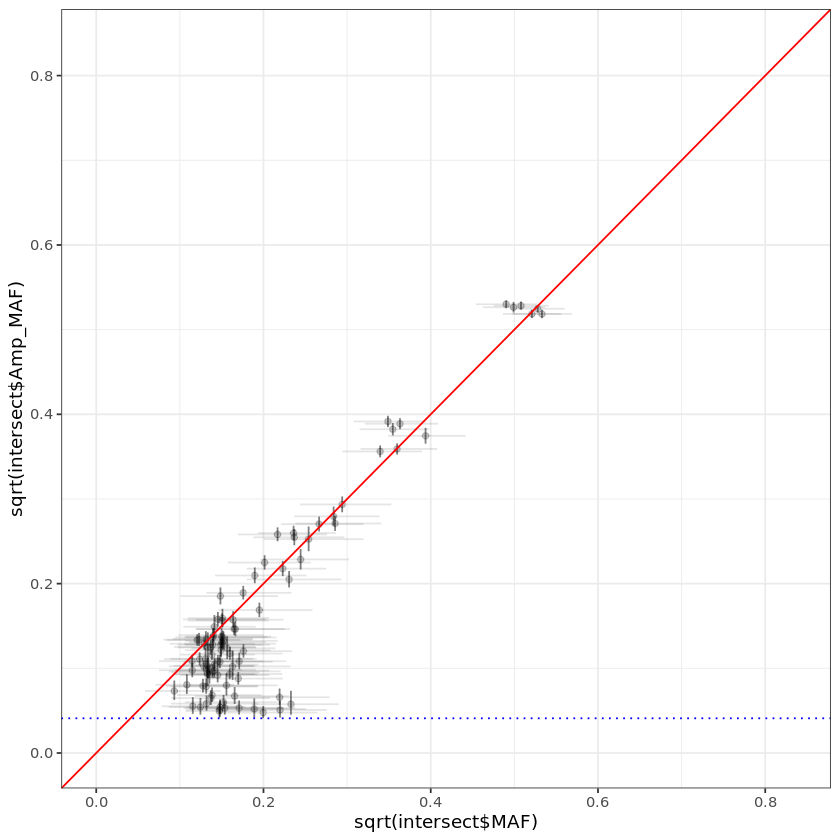

In [35]:
p

In [36]:
pdf(file = "./7614_WGS_TAseq_correlation.pdf",width = 6, height = 6);
p
dev.off()

png 
  2

In [37]:
min(intersect$Amp_LOWER_CI)
nrow(intersect)
length(unique(intersect$POS))

[1] 0.001691221

[1] 97

[1] 58

In [38]:
cor.test(sqrt(intersect$MAF), sqrt(intersect$Amp_MAF))


	Pearson's product-moment correlation

data:  sqrt(intersect$MAF) and sqrt(intersect$Amp_MAF)
t = 25.631, df = 95, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9037270 0.9559368
sample estimates:
      cor 
0.9346984 


In [48]:
filtered$Mosaic_shared_btw_WGS_Amp <- NA
filtered[filtered$CHROM.POS.REF.ALT %in% variants_287_7614,]$Mosaic_shared_btw_WGS_Amp <- 1
filtered[!(filtered$CHROM.POS.REF.ALT %in% variants_287_7614),]$Mosaic_shared_btw_WGS_Amp <- 0
nrow(filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,])
length(unique(filtered$Mosaic_shared_btw_WGS_Amp))

[1] 92127

[1] 2

# Lolliplot for everything

In [15]:
filtered<-read.table(file="./7614_final_summary_anno3.txt",header=T)
exclude<-read.table(file="./excluded_7614_samples.txt",header=T)

In [16]:
exclude

SAMPLE_ID
<chr>
7614-Heart-APX-bulk
7614-Heart-ART-1-bulk
7614-Heart-ART-2-bulk
7614-Heart-ART-3-bulk
7614-Heart-IVS-1-bulk
7614-Heart-IVS-1-sorted-cardimyocyte
7614-Heart-IVS-2-bulk
7614-Heart-IVS-2-sorted-cardimyocyte
7614-Heart-IVS-3-bulk


In [17]:
filtered<-subset(filtered, !(filtered$ID 
                        %in% exclude$SAMPLE_ID
                               #"7614−R−PF−DLX1","7614−R−T−72-TBR1","7614−R−T−74-TBR1","7614−R−P−DLX1")
                       ))

In [18]:
final <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,]
bks=c(0,0.001677998,0.005,0.1,0.20,0.3, 0.4706769 ,0.4,0.5,0.6,1)
pdf(file="Interneuron_7614_total_287_variants_2023_02_23_Plot2.pdf",width=32,height=9)
suppressWarnings(
for(i in 1:287){
temp<-final[final$CHROM.POS.REF.ALT==names(table(final$CHROM.POS.REF.ALT))[i],]
plot <-
ggplot(temp,aes(x=ID,y=sqrt(MAF),ymin=sqrt(LOWER_CI),ymax=sqrt(UPPER_CI)))+
	geom_point(alpha=0.5)+
	geom_pointrange()+
	geom_hline(yintercept=sqrt(0.001677998),linetype=2,col="black")+
  	geom_hline(yintercept=sqrt(0.4706769),linetype=2,col="black")+

	geom_hline(yintercept=sqrt(0.005),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.6),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.5),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.4),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(1),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0),linetype=2,col="grey")+
	scale_y_continuous(breaks=sqrt(bks),labels=bks)+
	scale_color_manual(values = c("pink","#2A3280","#A73326","#666666","#CCCCCC"))+
	theme_classic()+
	labs(title=paste0("ID01 ",names(table(final$CHROM.POS.REF.ALT))[i],x=""))+
	theme(axis.line=element_blank(),axis.text.x=element_text(face="bold",size=5,angle=90,vjust = 0.5))+
	geom_segment(aes(x = 0, y = 0, xend = 0, yend = 1),color="black")
print(plot)
})
dev.off()

png 
  2

In [51]:
head(filtered)
tail(filtered)
print(paste("Total number of rows : ", nrow(filtered),sep=""))
print(paste("Total number of input variant in ampliseq panel : ", length(unique(filtered$CHROM.POS.REF.ALT)),sep=""))
print(paste("Total number of mosaic variants shared between WGS and Ampliseq variant calls in the same tissue : ",
           length(unique(filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,]$CHROM.POS.REF.ALT)),sep=""))

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,UPPER_CI,CI_IS_GREATER,NORMAL_REF_COUNT,NORMAL_ALT_COUNT,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,Mosaic,Mosaic_shared_btw_WGS_Amp
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
1,7614-B-L-T,1,4262091,T,A,1-4262091-T-A,intergenic,"LINC01346(dist=249448),LINC01777(dist=210020)",6.270e-02,0,⋯,0.5066024661,PPPPP_PPPPP,24152,82,0.0033836758,0.0027270889,0.004197680,PPPPP_PPPPP,0,0
2,7614-B-L-T,1,5745160,G,A,1-5745160-G-A,intergenic,"MIR4417(dist=120957),MIR4689(dist=177572)",0.000e+00,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0
3,7614-B-L-T,1,5786487,C,T,1-5786487-C-T,intergenic,"MIR4417(dist=162284),MIR4689(dist=136245)",6.494e-05,0,⋯,0.0028859065,FFFFF_FFFFF,3588,2,0.0005571031,0.0001527911,0.002029125,FFFFF_FFFFF,1,0
4,7614-B-L-T,1,12559193,G,T,1-12559193-G-T,intronic,VPS13D,0.000e+00,0,⋯,0.0026244795,PFPFF_FPFFP,12963,9,0.0006938020,0.0003650641,0.001318176,FFFFF_FFFFF,1,0
5,7614-B-L-T,1,19931070,C,A,1-19931070-C-A,intronic,"MINOS1,MINOS1-NBL1",0.000e+00,0,⋯,0.5016418852,PPPPP_PPPPP,4158,33,0.0078740157,0.0056123020,0.011037066,PPPPP_PPPPP,0,0
6,7614-B-L-T,1,23121461,C,G,1-23121461-C-G,intronic,EPHB2,7.944e-01,0,⋯,0.0009441793,FFFFF_FFFFF,2350,2361,0.5011674804,0.4868945775,0.515438481,PPPPP_PPPPP,0,0


,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,UPPER_CI,CI_IS_GREATER,NORMAL_REF_COUNT,NORMAL_ALT_COUNT,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,Mosaic,Mosaic_shared_btw_WGS_Amp
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
335119,JGG-sorted,X,135481793,T,C,X-135481793-T-C,intronic,ADGRG4,0,0,⋯,0.0025147893,FFFFF_PFFFF,5752,5,0.0008685079,3.710299e-04,0.002031650,FFFFF_FFFFF,1,0
335120,JGG-sorted,X,138175923,C,T,X-138175923-C-T,intronic,FGF13,0,0,⋯,0.0024475209,FFFFF_FFFFF,1908,0,0.0000000000,-2.168404e-19,0.002009298,FFFFF_FFFFF,1,1
335121,JGG-sorted,X,138963618,G,T,X-138963618-G-T,intergenic,"ATP11C(dist=49171),MIR505(dist=42689)",0,0,⋯,0.0007011955,FFFFF_FFFFF,6756,4,0.0005917160,2.301301e-04,0.001520570,FFFFF_FFFFF,0,0
335122,JGG-sorted,X,139853112,G,A,X-139853112-G-A,ncRNA_intronic,LINC00632,0,0,⋯,0.0125723885,PPPPP_PPPPP,1805,15,0.0082417582,5.000969e-03,0.013554075,PPPPP_PPPPP,0,1
335123,JGG-sorted,X,141420247,C,G,X-141420247-C-G,intergenic,"MAGEC2(dist=127171),SPANXN4(dist=693457)",0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,1
335124,JGG-sorted,X,141942973,G,A,X-141942973-G-A,intergenic,"MAGEC2(dist=649897),SPANXN4(dist=170731)",0,0,⋯,0.0008698536,FFFFF_FFFFF,6046,2,0.0003306878,9.069122e-05,0.001205023,FFFFF_FFFFF,1,1


[1] "Total number of rows : 335124"
[1] "Total number of input variant in ampliseq panel : 1044"
[1] "Total number of mosaic variants shared between WGS and Ampliseq variant calls in the same tissue : 287"


In [52]:
write.table(filtered,"./7614_final_summary_anno3.txt",sep="\t", row.names=FALSE, col.names=TRUE)

In [122]:
#write.table(IDlist,"./annotation/7614_Ampliseq_annotation.csv",sep="\t", row.names=FALSE, col.names=TRUE)